In [1]:
import os
import pandas as pd

In [2]:
team_df_raw = pd.read_parquet('parquet_data/team_df_raw.parquet')
player_df_raw = pd.read_parquet('parquet_data/player_df_raw.parquet')

# Handling Missing Values
Some columns contain completely empty values. Let's drop them.

In [3]:
# Set pandas to display all columns
pd.set_option('display.max_columns', None)
# dropping
player_df_dropped= player_df_raw.drop(['Attend','Unnamed: 19','Unnamed: 20'],  axis='columns')
team_df_dropped=team_df_raw.drop(['Attend','Unnamed: 19','Unnamed: 20'],  axis='columns')

#### Handle missings for player base data 

let's get a correlation matrix first

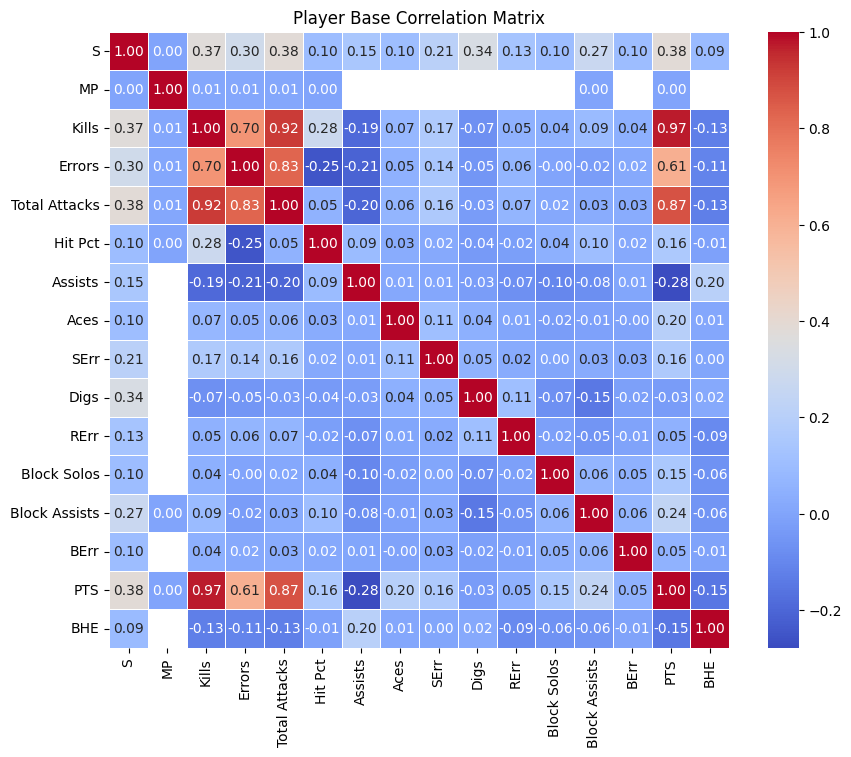

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sayısal sütunları belirtin
cols_numeric = ['S', 'MP', 'Kills', 'Errors', 'Total Attacks', 'Hit Pct', 'Assists', 'Aces', 
                'SErr', 'Digs', 'RErr', 'Block Solos', 'Block Assists', 'BErr', 'PTS', 'BHE']

# Sayısal sütunları seç
numeric_df = player_df_dropped[cols_numeric]
# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Draw the heat map
plt.figure(figsize=(10, 8))  # Görselleştirmeyi büyütmek için
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Player Base Correlation Matrix')
plt.show()

Kills, Errors adnTotal Attacks are very correlated with each other.<br>
* Kills: Bir oyuncunun rakip takımın defansını aşarak, doğrudan sayı kazandıran hücum vuruşlarının sayısını gösterir. Yani, başarılı hücumlar.
* 
Errors: Biryoyuncunun hücum sırasında yaptığı hatalar. Bu, topun rakip takım tarafından kurtarılamayacak şekilde dışarıya gitmesi veya bloklanması gibi hataları içer.
* Total Attacks: Bir oyuncunun toplam hücum denemelerinin sayısıdır. Kills ve Errors da dahil olmak üzere yapılan tüm hücumlar bu kategoriye girer.

<br>The PTS feature is correlated with the features we mentioned above
* PTS (Points): Bir oyuncunun veya takımın kazandığı toplam puan sayısıdır. Bu, hücumlardan, servislerden, bloklardan ve diğer oyun öğelerinden elde edilen puanları içerir.rer.

As can be seen from the correlation matrices, the MP value contains such a null value that its correlation with most features cannot be calculated. We can drop this column from our data sets.

In [5]:
# drop MP
player_df_dropped= player_df_dropped.drop(['MP'],  axis='columns')

let's see how much missing value there is in all the columns and what percentage of all the data is

In [6]:
# Find the number of null values in each column
null_summary = pd.DataFrame({
    'Null Count': player_df_dropped.isnull().sum(),
    'Null Percentage': (player_df_dropped.isnull().sum() / len(player_df_dropped)) * 100
})
# Null sayısına göre sıralama
sorted_null_summary = null_summary.sort_values(by='Null Count', ascending=True)

print(sorted_null_summary)

               Null Count  Null Percentage
Date                    0         0.000000
name                    0         0.000000
team_name               0         0.000000
Result                  0         0.000000
Opponent                0         0.000000
S                  196436        30.985160
Total Attacks      196522        30.998725
Kills              196529        30.999830
Errors             196556        31.004089
Digs               295094        46.547144
PTS                303013        47.796261
Hit Pct            354775        55.961026
Block Assists      436423        68.839910
Assists            456235        71.964989
SErr               460603        72.653983
Aces               512308        80.809757
RErr               532384        83.976478
BErr               580333        91.539794
Block Solos        581967        91.797536
BHE                601154        94.824029


Now, let's find the players in the main lineup 

Let's drop columns with missing values exceeding a given threshold and drops rows with any missing values from the remaining DataFrame. Prints the shape of the resulting DataFrame.

In [7]:
def clean_missing_data(df,threshold):
    """
    Drops columns with missing values exceeding a given threshold and drops rows with any missing values
    from the remaining DataFrame. Prints the shape of the resulting DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    threshold (float): The maximum percentage of missing values allowed in a column (0 to 100).

    Returns:
    pd.DataFrame: The cleaned DataFrame.
    """

    # Drop columns exceeding the threshold
    columns_to_drop = null_summary[null_summary['Null Percentage'] > threshold].index
    df_dropped = df.drop(columns=columns_to_drop)

    # Drop rows with any missing values in the remaining DataFrame
    df_cleaned = df_dropped.dropna()

    # Print the shape of the cleaned DataFrame with the threshold information
    print(f"Shape after cleaning (Threshold: {threshold}%): {df_cleaned.shape}")


In [8]:
for treshold in [50,60,70,80,90]:
    clean_missing_data(player_df_dropped,treshold)

Shape after cleaning (Threshold: 50%): (263488, 11)
Shape after cleaning (Threshold: 60%): (207904, 12)
Shape after cleaning (Threshold: 70%): (140188, 13)
Shape after cleaning (Threshold: 80%): (30801, 15)
Shape after cleaning (Threshold: 90%): (4768, 17)


trade-off: the number of rows decreases as the number of columns increases, the number of rows increases as the number of columns decreases.
shape of (30801, 15) is ideal for out project.

Aces 80.809757<br>
RErr 83.976478<br>
BErr 91.539794<br>
Block Solos 91.797536<br>
BHE 94.824029

In [9]:
player_df_dropped_row= player_df_dropped.drop(['Aces','RErr','BErr','Block Solos','BHE'],  axis='columns')
# Kalan kolonlarda eksik değeri olmayan satırları seçme
player_df_dropped_row = player_df_dropped_row.dropna()
player_df_dropped_row

,Date,Opponent,Result,S,Kills,Errors,Total Attacks,Hit Pct,Assists,SErr,Digs,Block Assists,PTS,name,team_name
10,09/17/2016,@ Yale,L 1 - 3,4.0,14.0,3.0,37.0,0.297,3.0,1.0,5.0,3.0,16.5,"Carlson, Morgan",A&M-Corpus Christi (Southland)
19,10/15/2016,Lamar University,W 3 - 0,3.0,8.0,3.0,20.0,0.250,3.0,1.0,3.0,4.0,10.0,"Carlson, Morgan",A&M-Corpus Christi (Southland)
20,10/20/2016,@ New Orleans,W 3 - 1,4.0,9.0,3.0,21.0,0.286,1.0,2.0,5.0,3.0,11.5,"Carlson, Morgan",A&M-Corpus Christi (Southland)
24,11/03/2016,McNeese,W 3 - 0,3.0,9.0,1.0,17.0,0.471,1.0,1.0,6.0,2.0,10.0,"Carlson, Morgan",A&M-Corpus Christi (Southland)
27,11/12/2016,@ Houston Baptist,W 3 - 1,4.0,7.0,6.0,21.0,0.048,1.0,2.0,8.0,4.0,9.0,"Carlson, Morgan",A&M-Corpus Christi (Southland)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633820,11/08/2019,@ Green Bay,L 0 - 3,3.0,9.0,8.0,32.0,0.031,1.0,2.0,12.0,3.0,13.5,"Pe'a, Brooklen",Youngstown St. (Horizon)
633955,10/05/2019,Milwaukee,L 0 - 3,3.0,10.0,3.0,38.0,0.184,1.0,3.0,12.0,1.0,10.5,"Thompson, Margaux",Youngstown St. (Horizon)
633956,10/09/2019,@ IUPUI,W 3 - 2,5.0,17.0,6.0,37.0,0.297,1.0,5.0,21.0,1.0,20.5,"Thompson, Margaux",Youngstown St. (Horizon)
633957,10/11/2019,Green Bay,L 0 - 3,3.0,3.0,7.0,26.0,-0.154,1.0,2.0,12.0,1.0,3.5,"Thompson, Margaux",Youngstown St. (Horizon)


there is no missing value in our player-based data set

#### Handle missings for team base data

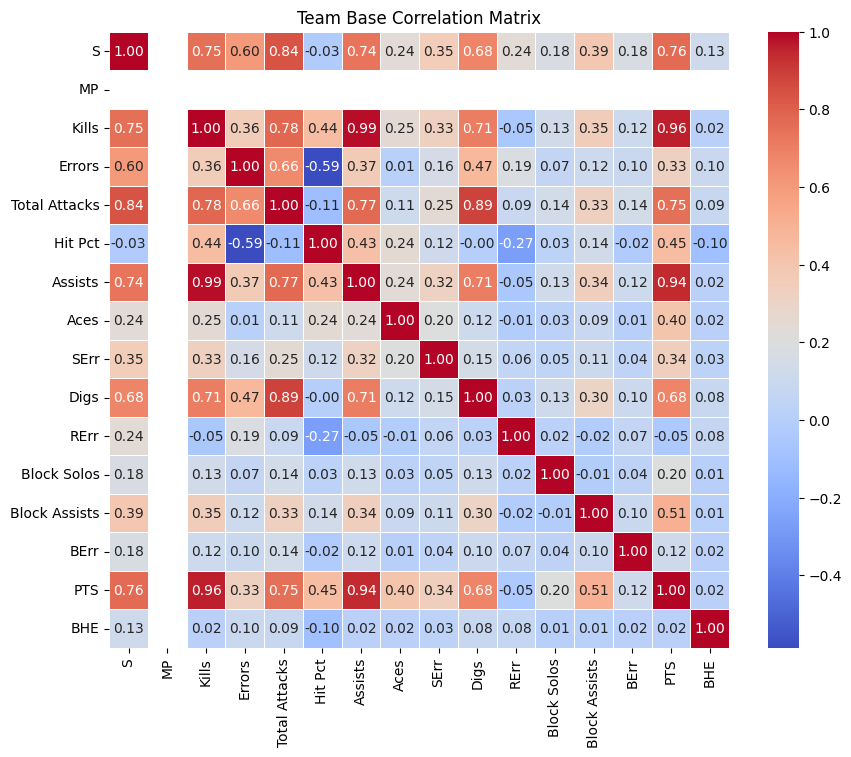

In [10]:
# Sayısal sütunları belirtin
cols_numeric = ['S', 'MP', 'Kills', 'Errors', 'Total Attacks', 'Hit Pct', 'Assists', 'Aces', 
                'SErr', 'Digs', 'RErr', 'Block Solos', 'Block Assists', 'BErr', 'PTS', 'BHE']

# Sayısal sütunları seç
numeric_df = team_df_dropped[cols_numeric]
# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Draw the heat map
plt.figure(figsize=(10, 8))  # Görselleştirmeyi büyütmek için
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Team Base Correlation Matrix')
plt.show()

As can be seen from the correlation matrices, the MP value contains such a null value that its correlation with most features cannot be calculated. We can drop this column from our data sets.

In [11]:
# drop MP
team_df_dropped=team_df_dropped.drop(['MP'],  axis='columns')

let's see how much missing value there is in all the columns and what percentage of all the data is

In [12]:
# Find the number of null values in each column
null_summary = pd.DataFrame({
    'Null Count': team_df_dropped.isnull().sum(),
    'Null Percentage': (team_df_dropped.isnull().sum() / len(team_df_dropped)) * 100
})
# Null sayısına göre sıralama
sorted_null_summary = null_summary.sort_values(by='Null Count', ascending=True)

print(sorted_null_summary)

               Null Count  Null Percentage
Date                    0         0.000000
Result                  0         0.000000
name                    0         0.000000
Opponent                0         0.000000
S                      43         0.107069
Hit Pct               172         0.428276
Total Attacks         173         0.430766
Digs                  181         0.450686
Kills                 186         0.463136
Assists               193         0.480566
Errors                202         0.502976
SErr                  336         0.836633
PTS                   625         1.556236
Block Assists         810         2.016882
Aces                 1407         3.503399
RErr                 1439         3.583078
Block Solos         10528        26.214487
BErr                11743        29.239810
BHE                 16860        41.981026


In [13]:
for treshold in [1,2,3,20,40]:
    clean_missing_data(team_df_dropped,treshold)

Shape after cleaning (Threshold: 1%): (39175, 12)
Shape after cleaning (Threshold: 2%): (38685, 13)
Shape after cleaning (Threshold: 3%): (37953, 14)
Shape after cleaning (Threshold: 20%): (35355, 16)
Shape after cleaning (Threshold: 40%): (18739, 18)


In [14]:
team_df_dropped_row= team_df_dropped.drop(['BErr','Block Solos','BHE'],  axis='columns')
# Kalan kolonlarda eksik değeri olmayan satırları seçme
team_df_dropped_row = team_df_dropped_row.dropna()
team_df_dropped_row

,Date,Opponent,Result,S,Kills,Errors,Total Attacks,Hit Pct,Assists,Aces,SErr,Digs,RErr,Block Assists,PTS,name
0,08/26/2016,"Prairie View @ Waco, Texas",W 3 - 0,3.0,46.0,13.0,107.0,0.308,40.0,6.0,11.0,51.0,3.0,2.0,53.0,A&M-Corpus Christi (Southland)
1,08/27/2016,@ Baylor,L 1 - 3,4.0,37.0,20.0,119.0,0.143,32.0,5.0,6.0,46.0,5.0,18.0,53.0,A&M-Corpus Christi (Southland)
3,09/03/2016,"San Diego @ Madison, Wis.",L 0 - 3,3.0,30.0,16.0,94.0,0.149,29.0,1.0,3.0,32.0,1.0,15.0,42.5,A&M-Corpus Christi (Southland)
5,09/06/2016,UTRGV,W 3 - 1,4.0,53.0,20.0,158.0,0.209,49.0,3.0,9.0,66.0,2.0,16.0,66.0,A&M-Corpus Christi (Southland)
6,09/09/2016,UNLV,L 1 - 3,4.0,44.0,30.0,166.0,0.084,42.0,1.0,3.0,66.0,2.0,8.0,52.0,A&M-Corpus Christi (Southland)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40155,11/01/2019,Cleveland St.,L 0 - 3,3.0,27.0,17.0,101.0,0.099,27.0,3.0,3.0,38.0,5.0,8.0,34.0,Youngstown St. (Horizon)
40156,11/03/2019,@ Oakland,L 0 - 3,3.0,26.0,22.0,119.0,0.034,24.0,5.0,7.0,40.0,4.0,6.0,35.0,Youngstown St. (Horizon)
40157,11/06/2019,IUPUI,L 2 - 3,5.0,56.0,20.0,149.0,0.242,53.0,8.0,8.0,63.0,8.0,12.0,71.0,Youngstown St. (Horizon)
40159,11/15/2019,Wright St.,L 0 - 3,3.0,28.0,19.0,113.0,0.080,27.0,1.0,4.0,43.0,6.0,6.0,32.0,Youngstown St. (Horizon)


In [15]:
# Save the combined DataFrames to parquet files
output_dir='parquet_data'
os.makedirs(output_dir, exist_ok=True) # Ensure the output directory exists

team_parquet_path = os.path.join(output_dir, 'team_df_missing_handled.parquet')
player_parquet_path = os.path.join(output_dir, 'player_df_missing_handled.parquet')

team_df_dropped_row.to_parquet(team_parquet_path, index=False)
player_df_dropped_row.to_parquet(player_parquet_path, index=False)